# Import



In [1]:
### Import des bibliothèques principales
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from yellowbrick.classifier import ClassificationReport
from sklearn.impute import KNNImputer
from sklearn.preprocessing import RobustScaler
import pandas as pd

### Configuration des options pour les graphiques
%matplotlib inline
sns.set(style="whitegrid")


## Merged data

In [2]:

### Charger les datasets
# dataframe depuis kaggle
heart_data_1 = pd.read_csv('../heart_disease_uci.csv')
# dataframe depuis source
heart_data_2 = pd.read_csv('../HeartDiseaseUCI.csv')

### Afficher un aperçu des données
display(heart_data_1.head())
display(heart_data_2.head())

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


,Unnamed: 0,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,1,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
1,2,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
2,3,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
3,4,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
4,5,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0


In [3]:
print(f"heart data 1 shape{heart_data_1.shape}")
print(f"heart data 2 shape{heart_data_2.shape}")

heart data 1 shape(920, 16)
heart data 2 shape(303, 15)


In [4]:


# Step 1: Rename specific columns in heart_data_1 to match heart_data_2
# Renaming 'id' to 'Unnamed: 0' and 'thalch' to 'thalach'
heart_data_1 = heart_data_1.rename(columns={'id': 'Unnamed: 0', 'thalch': 'thalach'})

# Step 2: Define mappings for categorical variables
# Chest pain type (cp)
cp_mapping = {
    "typical angina": 1,
    "atypical angina": 2,
    "non-anginal": 3,
    "asymptomatic": 4
}

# Resting ECG results (restecg)
restecg_mapping = {
    "normal": 0,
    "lv hypertrophy": 1,
    "st-t abnormality": 2
}

# Slope of the peak exercise ST segment (slope)
slope_mapping = {
    "upsloping": 1,
    "flat": 2,
    "downsloping": 3
}

# Thalassemia (thal)
thal_mapping = {
    "normal": 3,
    "fixed defect": 6,
    "reversable defect": 7
}

# Mapping for sex
sex_mapping = {
    "Male": 1,
    "Female": 0
}

# Step 3: Apply mappings to transform heart_data_1
heart_data_1['cp'] = heart_data_1['cp'].map(cp_mapping)
heart_data_1['restecg'] = heart_data_1['restecg'].map(restecg_mapping)
heart_data_1['slope'] = heart_data_1['slope'].map(slope_mapping)
heart_data_1['thal'] = heart_data_1['thal'].map(thal_mapping)
heart_data_1['sex'] = heart_data_1['sex'].map(sex_mapping)

# Step 4: Convert boolean columns to integers (0 and 1)
heart_data_1['fbs'] = heart_data_1['fbs'].astype(float)
heart_data_1['exang'] = heart_data_1['exang'].astype(float)

# Step 5: Ensure columns in heart_data_1 match the columns in heart_data_2
heart_data_1 = heart_data_1[heart_data_2.columns]

# Step 6: Merge the two DataFrames and drop duplicates
merged_df = pd.concat([heart_data_1, heart_data_2], ignore_index=True)
merged_df = merged_df.drop_duplicates()

# Display the first few rows of the merged DataFrame
print(merged_df.head())


   Unnamed: 0  age  sex  cp  trestbps   chol  fbs  restecg  thalach  exang  \
0           1   63    1   1     145.0  233.0  1.0      1.0    150.0    0.0   
1           2   67    1   4     160.0  286.0  0.0      1.0    108.0    1.0   
2           3   67    1   4     120.0  229.0  0.0      1.0    129.0    1.0   
3           4   37    1   3     130.0  250.0  0.0      0.0    187.0    0.0   
4           5   41    0   2     130.0  204.0  0.0      1.0    172.0    0.0   

   oldpeak  slope   ca  thal  num  
0      2.3    3.0  0.0   6.0    0  
1      1.5    2.0  3.0   3.0    2  
2      2.6    2.0  2.0   7.0    1  
3      3.5    3.0  0.0   3.0    0  
4      1.4    1.0  0.0   3.0    0  


### Explication rapide des colonnes et valeurs

Unnamed: 0 : Identifiant unique de chaque observation.
age : Âge du patient.
sex : Sexe du patient (1 = Homme, 0 = Femme).
cp : Type de douleur thoracique (chest pain type) :

    1 : Angine typique
    2 : Angine atypique
    3 : Douleur non angineuse
    4 : Asymptomatique

trestbps : Pression artérielle au repos en mm Hg.
chol : Niveau de cholestérol sérique en mg/dl.
fbs : Glycémie à jeun > 120 mg/dl (1 = Vrai ; 0 = Faux).
restecg : Résultats de l'électrocardiogramme au repos :

    0 : Normal
    1 : Hypertrophie ventriculaire gauche (lv hypertrophy)
    2 : Anomalie de ST-T

thalach : Fréquence cardiaque maximale atteinte.
exang : Angine induite par l'exercice (1 = Oui ; 0 = Non).
oldpeak : Dépression de ST induite par l'exercice par rapport au repos.
slope : Pente du segment ST lors du pic d'exercice :

    1 : Pente montante (upsloping)
    2 : Pente plate (flat)
    3 : Pente descendante (downsloping)

ca : Nombre de vaisseaux principaux (0-3) colorés par fluoroscopie.
thal : Résultats du test thalium :

    3 : Normal
    6 : Défaut fixe (fixed defect)
    7 : Défaut réversible (reversable defect)

num : Indicateur de présence de maladie cardiaque (0 = Absence ; 1-4 = Présence).

In [5]:
merged_df.shape

(1072, 15)

Valeurs manquantes par colonne :
 Unnamed: 0      0
age             0
sex             0
cp              0
trestbps       59
chol           30
fbs            90
restecg         2
thalach        55
exang          55
oldpeak        62
slope         309
ca            612
thal          487
num             0
dtype: int64

Statistiques descriptives :
        Unnamed: 0          age          sex           cp     trestbps  \
count  1072.000000  1072.000000  1072.000000  1072.000000  1013.000000   
mean    415.123134    53.843284     0.774254     3.247201   132.465943   
std     272.047326     9.356996     0.418268     0.939581    18.965125   
min       1.000000    28.000000     0.000000     1.000000     0.000000   
25%     172.750000    47.750000     1.000000     3.000000   120.000000   
50%     384.500000    55.000000     1.000000     4.000000   130.000000   
75%     652.250000    60.000000     1.000000     4.000000   140.000000   
max     920.000000    77.000000     1.000000     4.000000   20

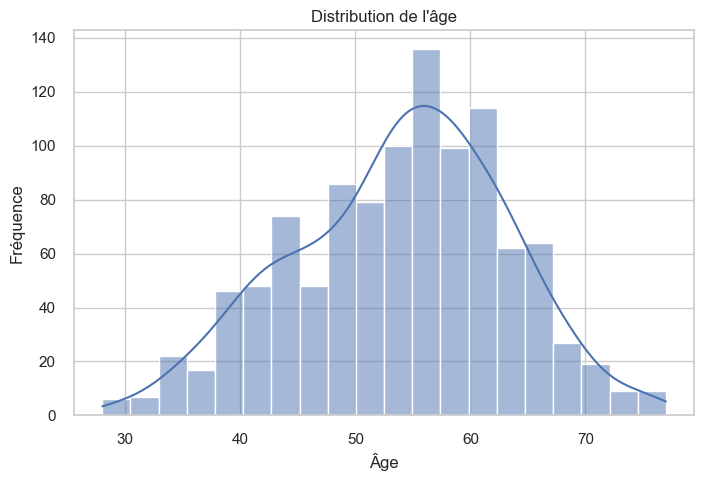

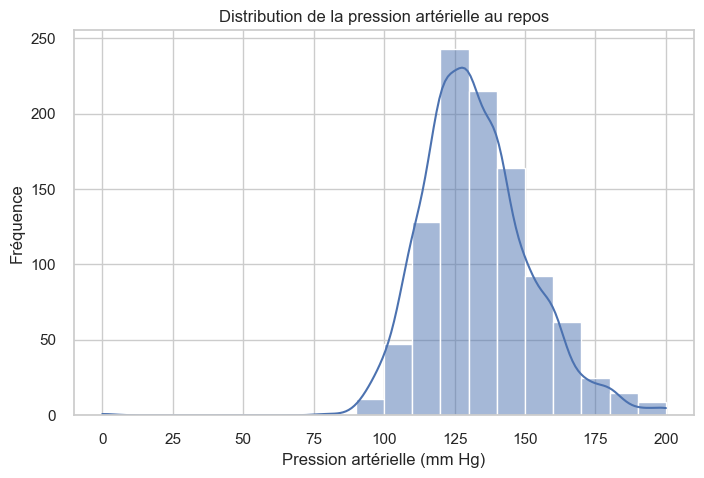

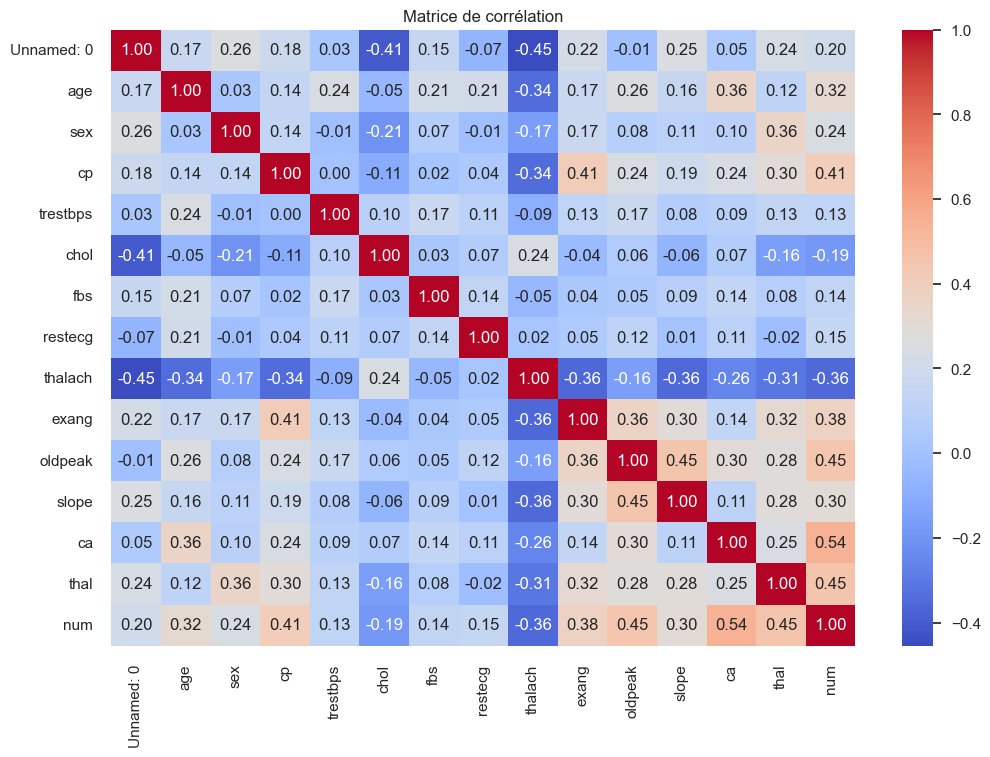

In [6]:
# Vérifier les valeurs manquantes
print("Valeurs manquantes par colonne :\n", merged_df.isnull().sum())

# Afficher les statistiques descriptives
print("\nStatistiques descriptives :")
print(merged_df.describe())

# Visualiser la distribution de l'âge
plt.figure(figsize=(8, 5))
sns.histplot(merged_df['age'], bins=20, kde=True)
plt.title("Distribution de l'âge")
plt.xlabel("Âge")
plt.ylabel("Fréquence")
plt.show()

# Visualiser la distribution de la pression artérielle au repos
plt.figure(figsize=(8, 5))
sns.histplot(merged_df['trestbps'], bins=20, kde=True)
plt.title("Distribution de la pression artérielle au repos")
plt.xlabel("Pression artérielle (mm Hg)")
plt.ylabel("Fréquence")
plt.show()

# Visualiser la corrélation entre les variables
plt.figure(figsize=(12, 8))
sns.heatmap(merged_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matrice de corrélation")
plt.show()

### Plotting


#### Numérique


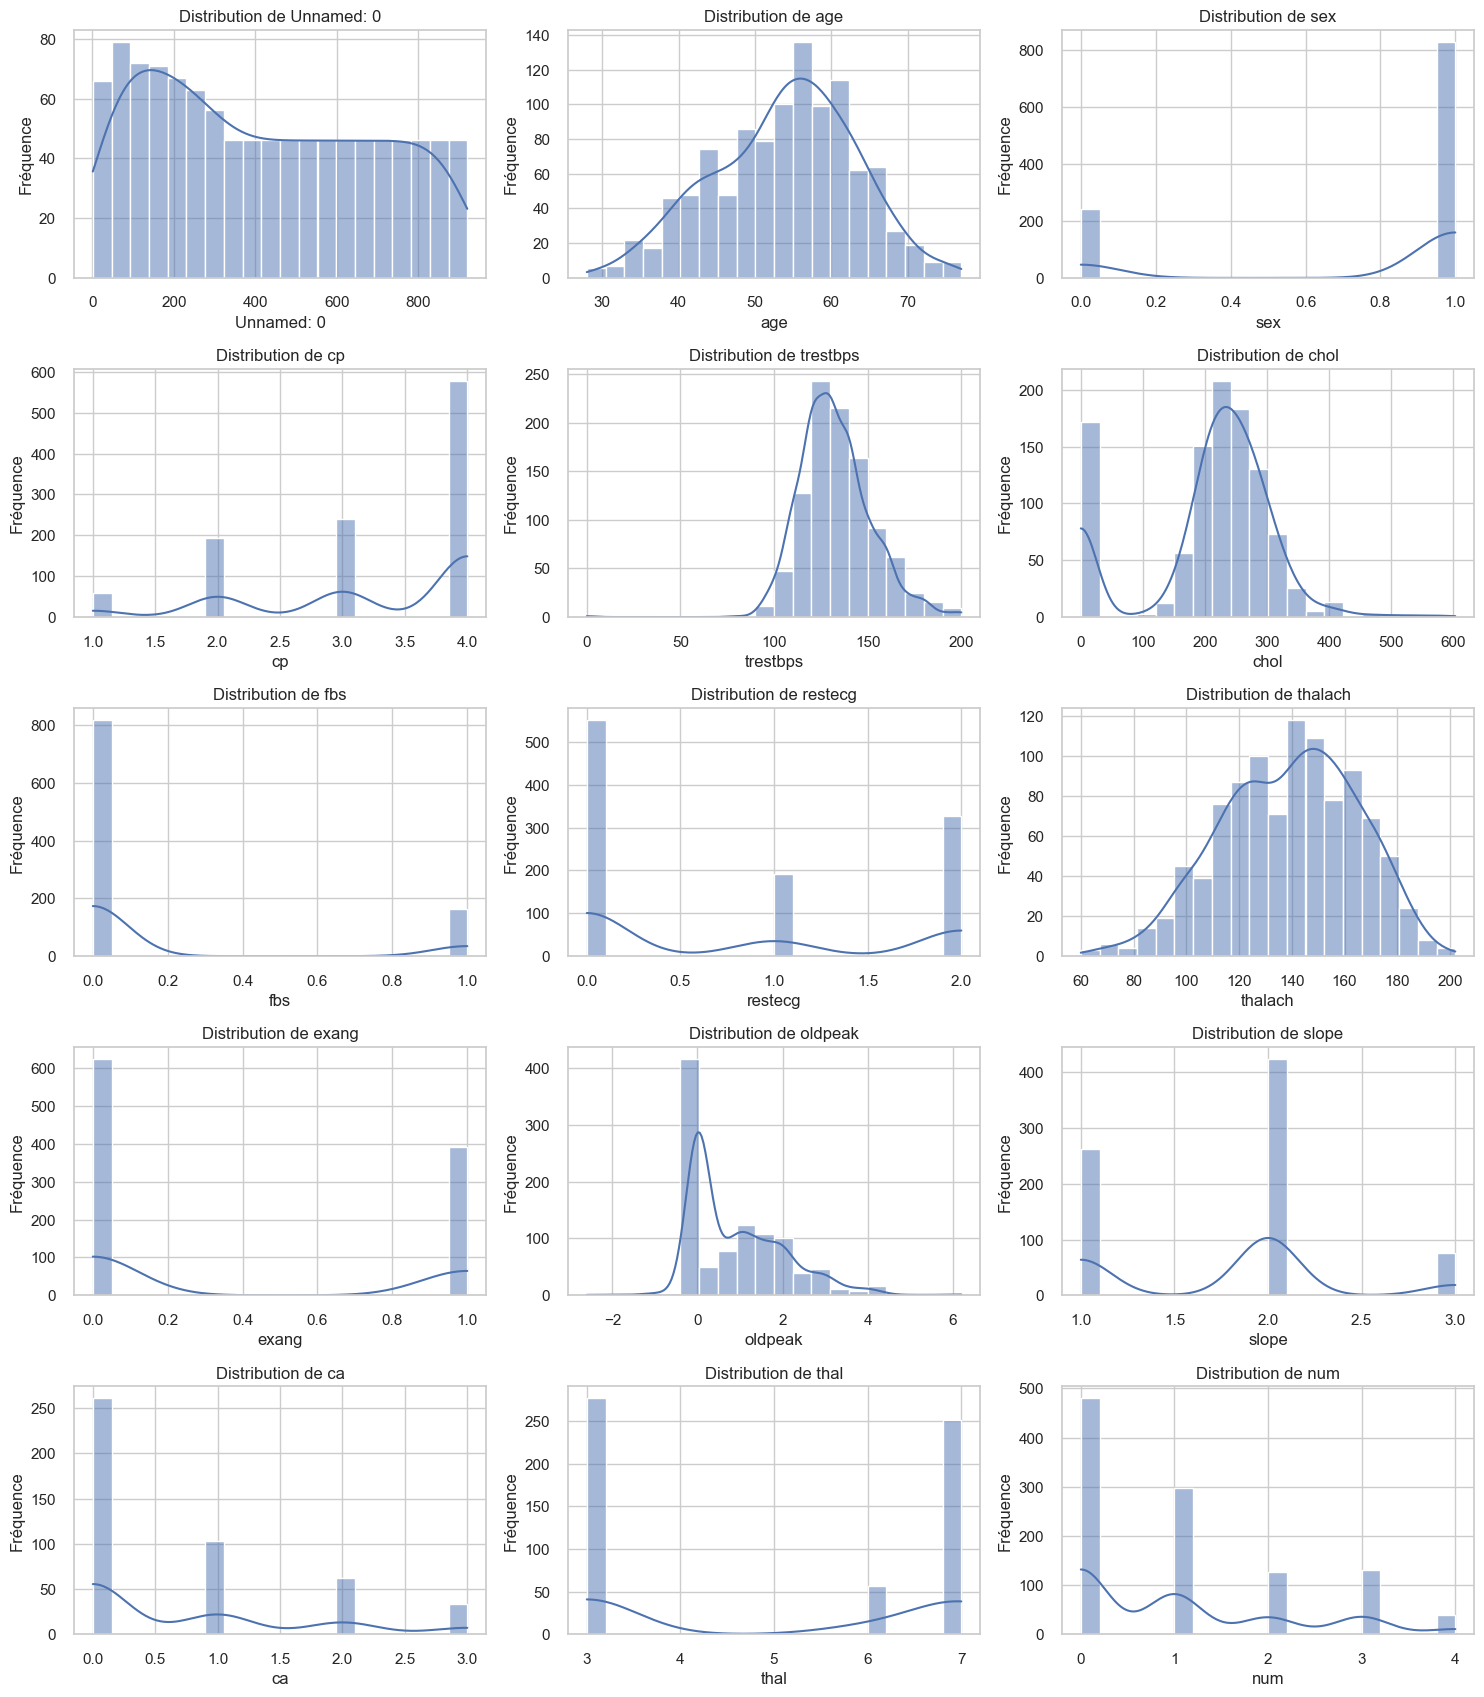

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sélectionner les colonnes numériques
numeric_columns = merged_df.select_dtypes(include=['float64', 'int64']).columns

# Configuration de la grille de plots pour les distributions
plt.figure(figsize=(15, 20))
for i, col in enumerate(numeric_columns, 1):
    plt.subplot(len(numeric_columns) // 3 + 1, 3, i)
    sns.histplot(merged_df[col], kde=True, bins=20)
    plt.title(f"Distribution de {col}")
    plt.xlabel(col)
    plt.ylabel("Fréquence")

plt.tight_layout()
plt.show()

 #### Catégoritielle

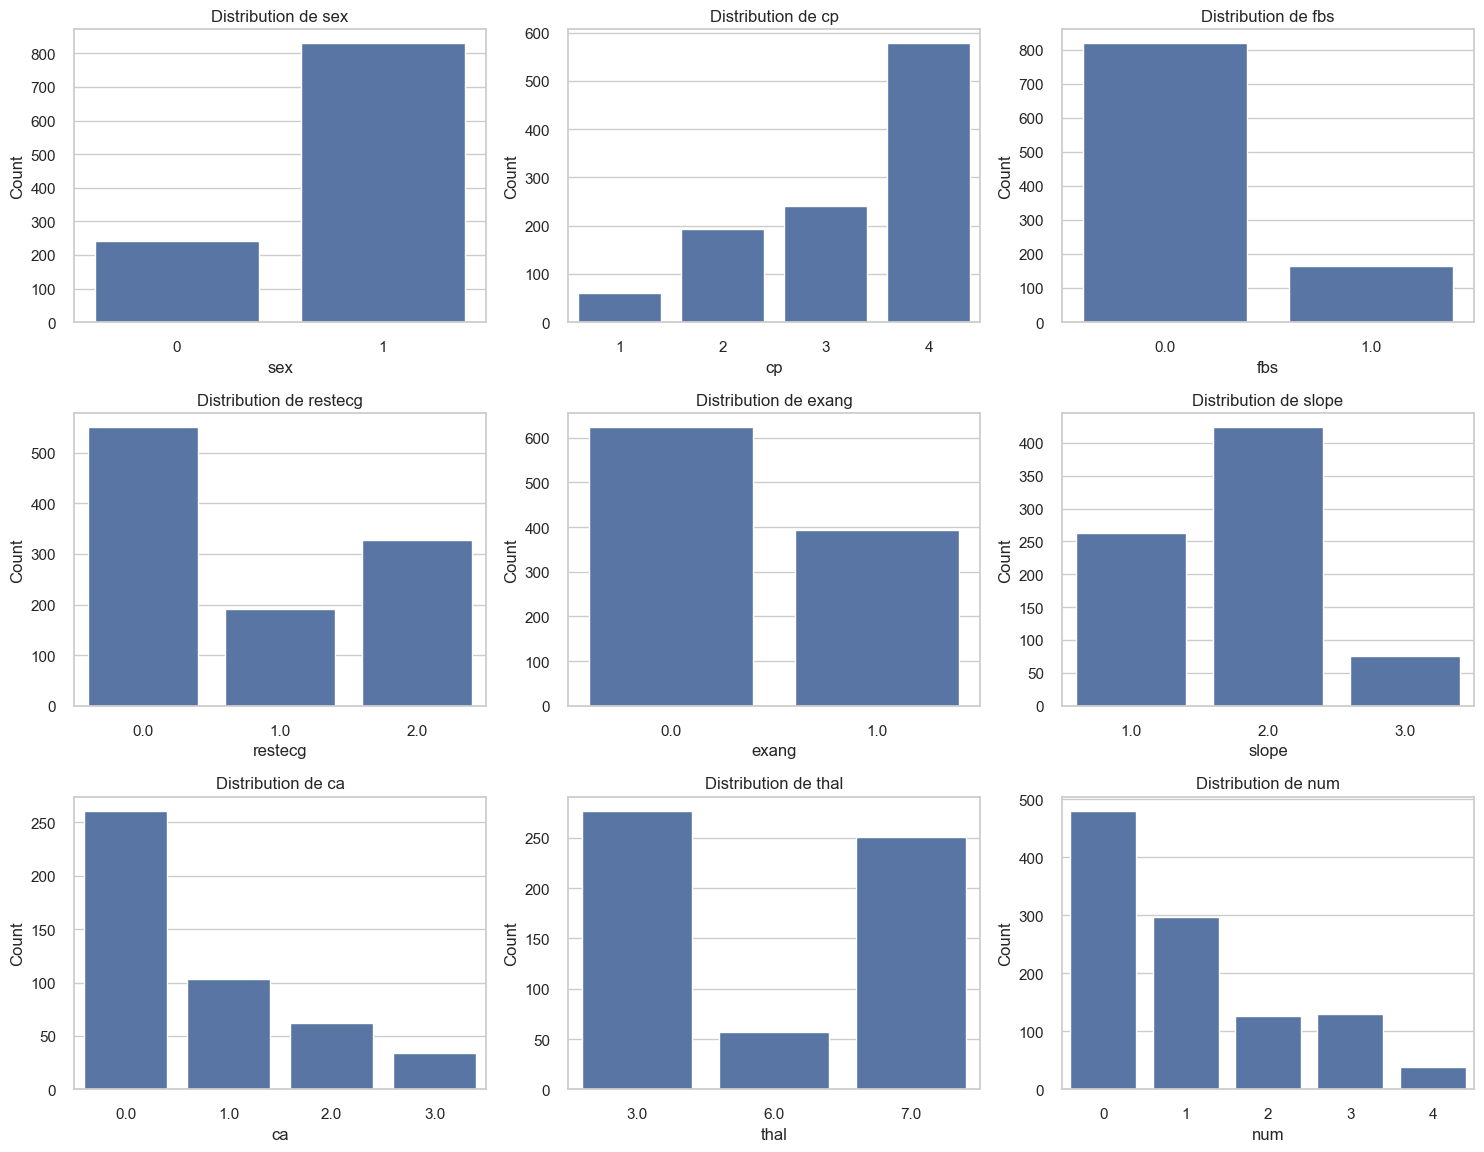

In [8]:
categorical_columns = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal', 'num']

# Configuration de la grille de plots
plt.figure(figsize=(15, 15))
for i, col in enumerate(categorical_columns, 1):
    plt.subplot(len(categorical_columns) // 3 + 1, 3, i)
    sns.countplot(data=merged_df, x=col)
    plt.title(f"Distribution de {col}")
    plt.xlabel(col)
    plt.ylabel("Count")

plt.tight_layout()
plt.show()

### Analyse Bivarié

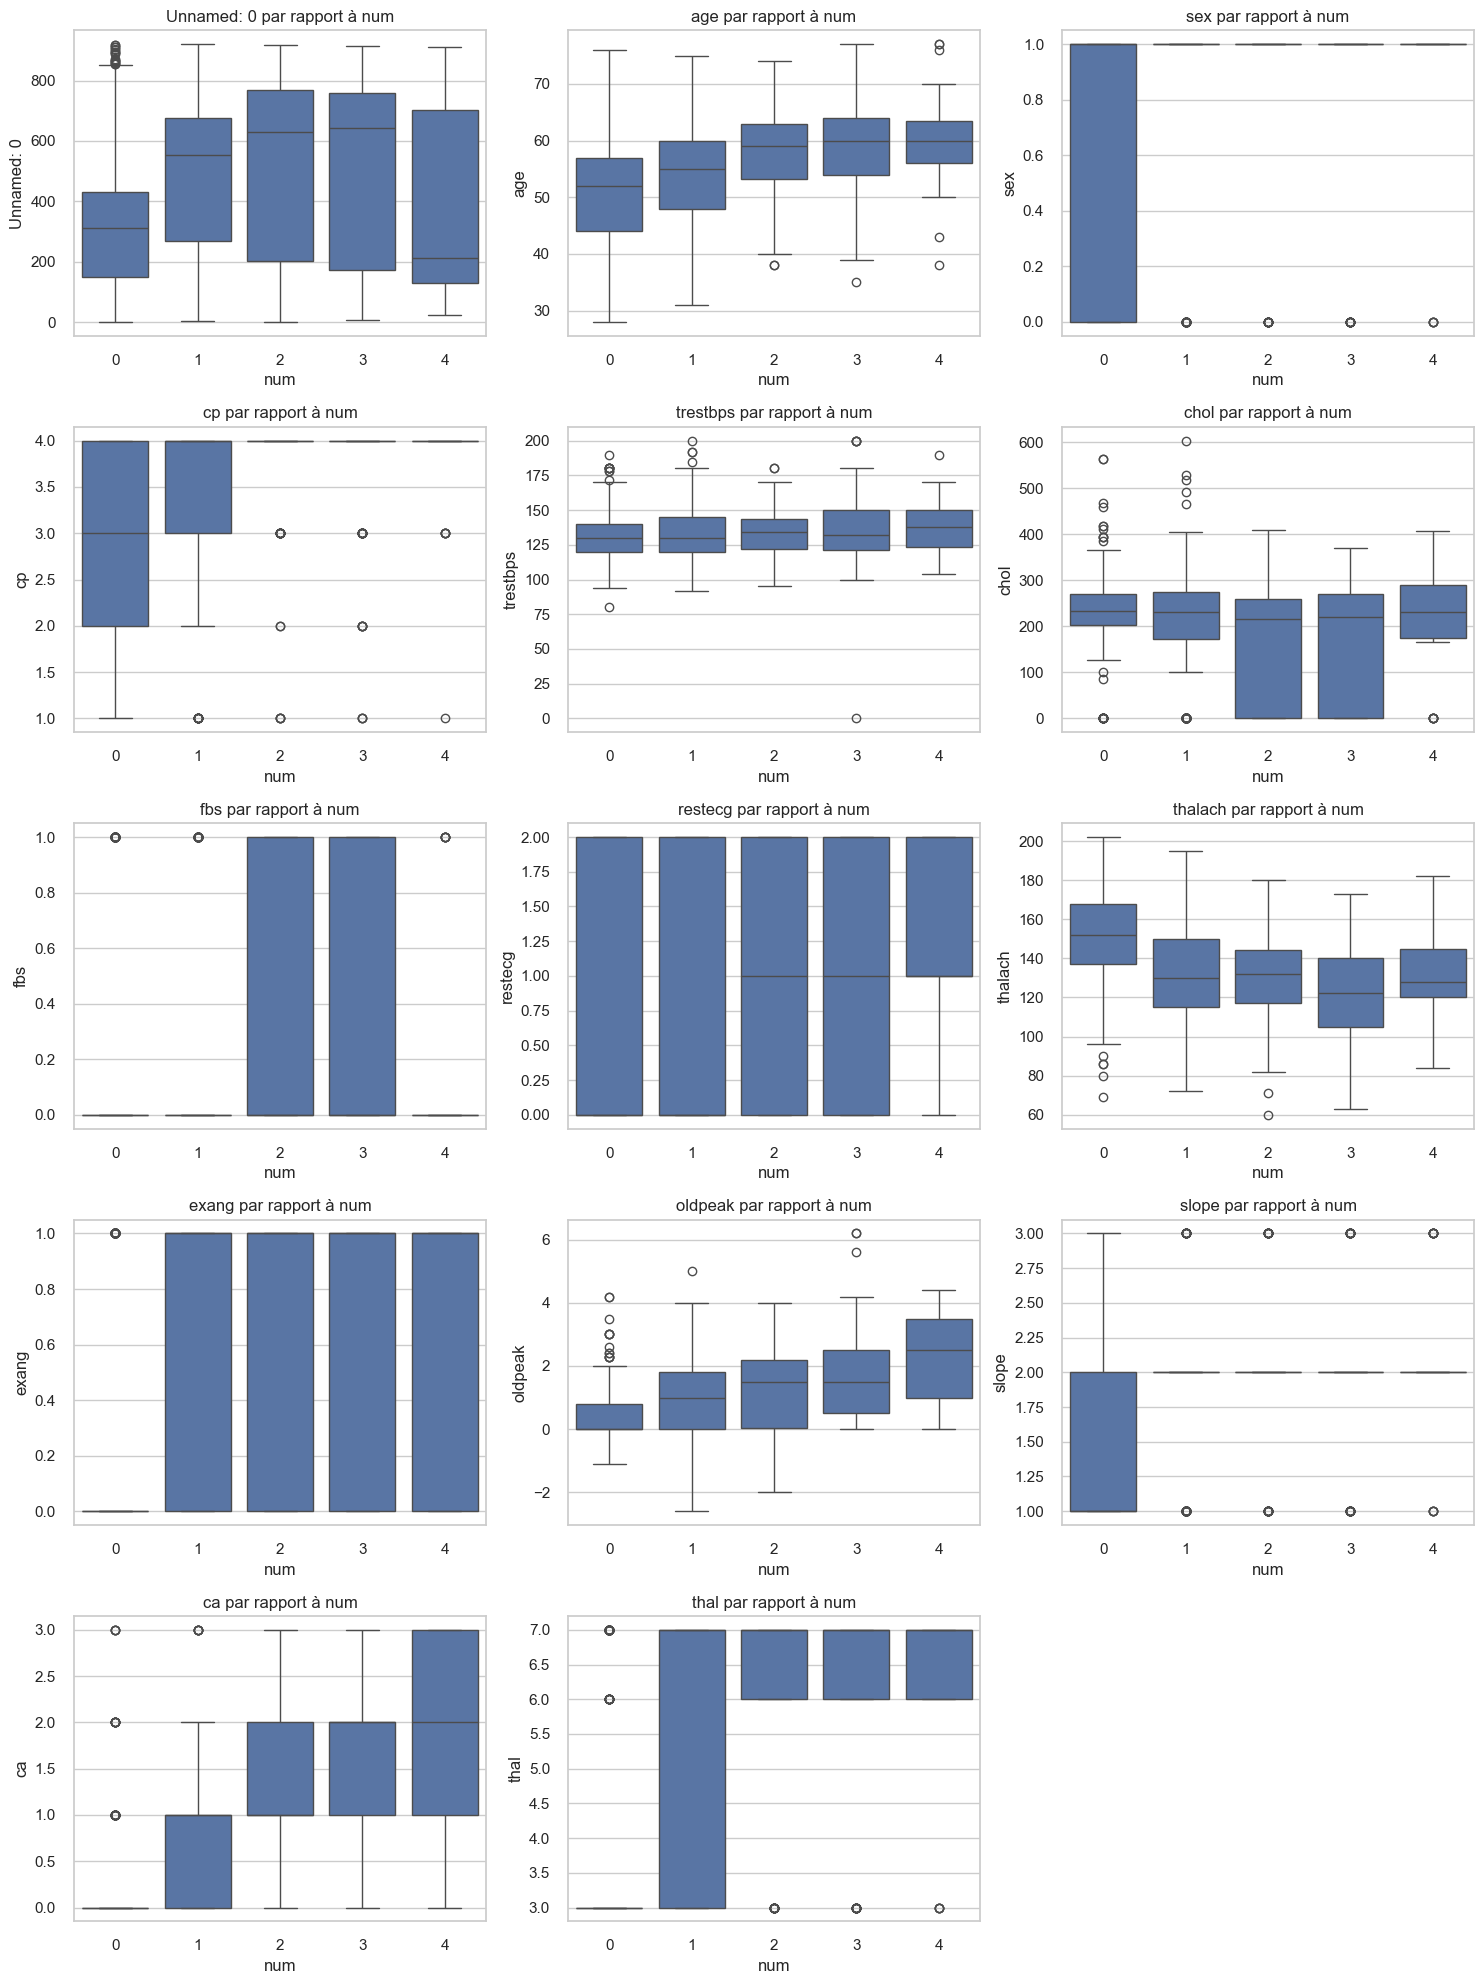

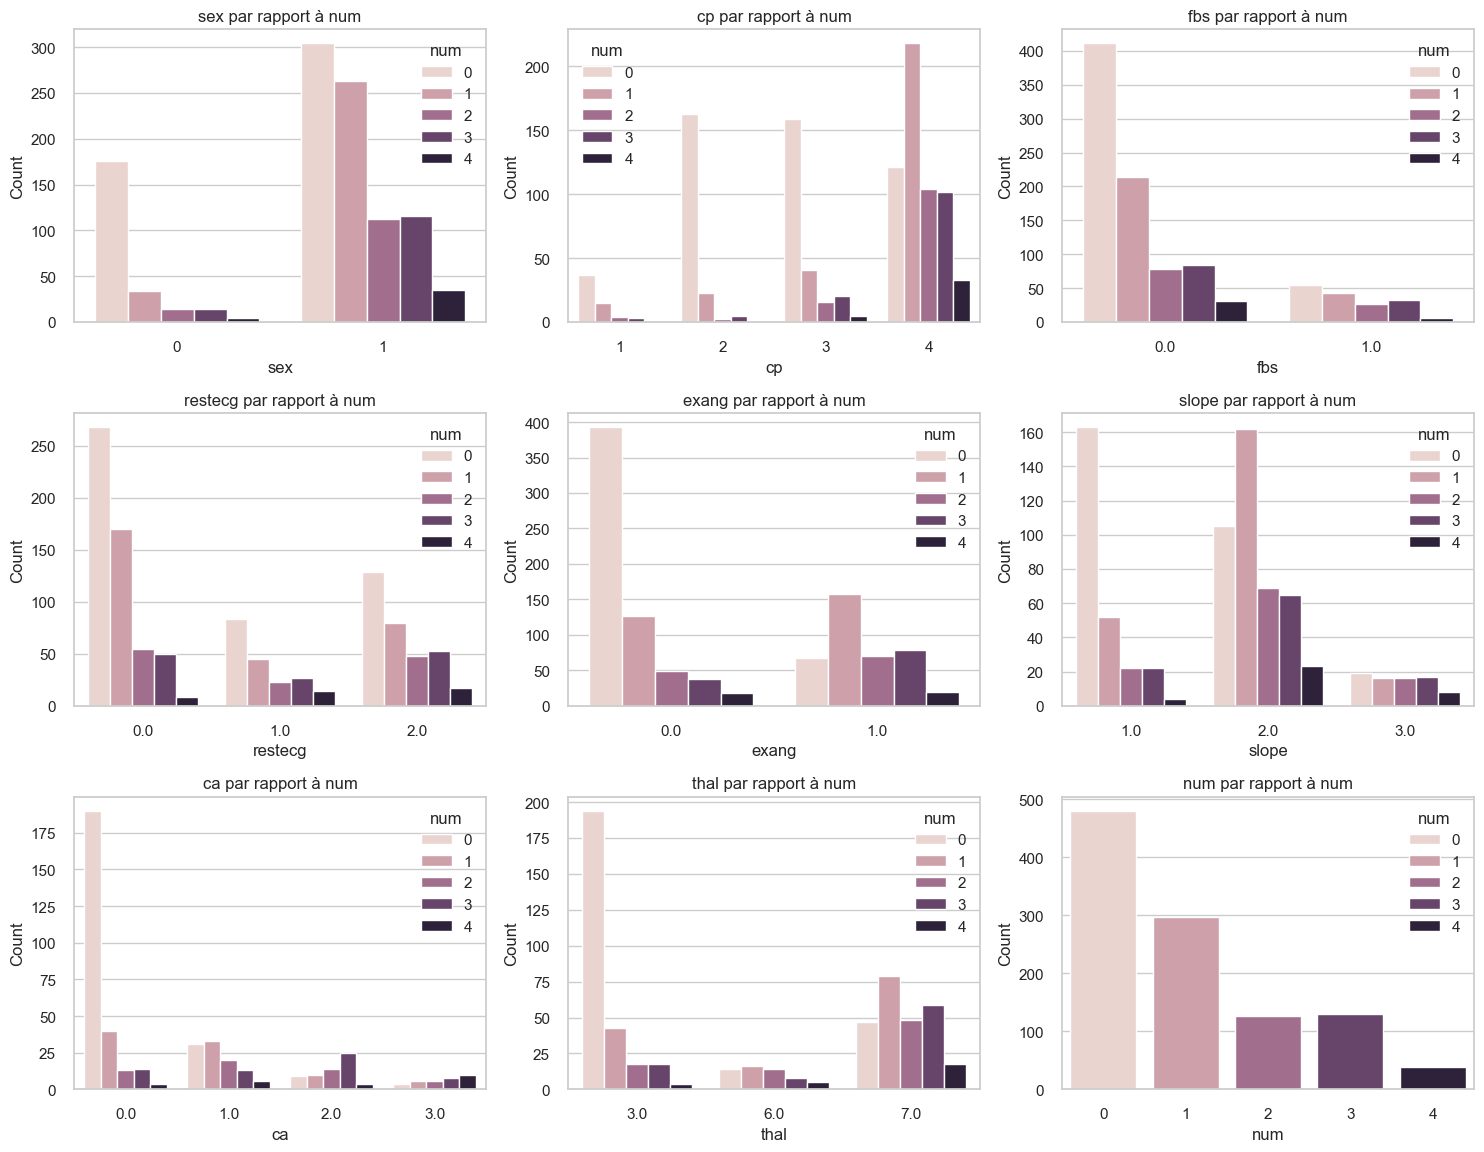

In [9]:
# Analyse bivariée avec la variable cible `num`
target_column = 'num'
numeric_features = merged_df.select_dtypes(include=['float64', 'int64']).columns.drop(target_column)

# Visualisation des variables numériques par rapport à la cible avec des boxplots
plt.figure(figsize=(15, 20))
for i, col in enumerate(numeric_features, 1):
    plt.subplot(len(numeric_features) // 3 + 1, 3, i)
    sns.boxplot(data=merged_df, x=target_column, y=col)
    plt.title(f"{col} par rapport à {target_column}")
    plt.xlabel(target_column)
    plt.ylabel(col)

plt.tight_layout()
plt.show()

# Visualisation des variables catégorielles par rapport à la cible avec des countplots
plt.figure(figsize=(15, 15))
for i, col in enumerate(categorical_columns, 1):
    plt.subplot(len(categorical_columns) // 3 + 1, 3, i)
    sns.countplot(data=merged_df, x=col, hue=target_column)
    plt.title(f"{col} par rapport à {target_column}")
    plt.xlabel(col)
    plt.ylabel("Count")

plt.tight_layout()
plt.show()


### Suite à l'observation : traitement des données

In [10]:
merged_df.dtypes

Unnamed: 0      int64
age             int64
sex             int64
cp              int64
trestbps      float64
chol          float64
fbs           float64
restecg       float64
thalach       float64
exang         float64
oldpeak       float64
slope         float64
ca            float64
thal          float64
num             int64
dtype: object

### Transforme data

Choix de l'imputation et du scaler:

L'imputation KNN a été choisi afin de conserver la distribution ainsi que la relation entre les colonnes. en effet, nous nous basons sur la positions des points dans l'espace et la distance entre ces derniers: cela est la stratégie adaptée car les disstributions ne respectent pas la loi Gaussienne

RobustScaler est préféré dans ce contexte parce qu’il est moins sensible aux valeurs extrêmes (outliers). Contrairement à StandardScaler, qui utilise la moyenne et l’écart-type, RobustScaler se base sur la médiane et les quartiles. Cela permet d'avoir une distribution normalisée tout en réduisant l'impact des valeurs anormalement élevées ou basses, ce qui est pertinent pour des variables comme chol ou oldpeak, qui peuvent présenter des valeurs extrêmes.

Cette préparation rend les données homogènes et prêtes pour une analyse de classification sans distorsion excessive due aux outliers.

In [11]:
merged_df

,Unnamed: 0,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,1,63,1,1,145.0,233.0,1.0,1.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,2,67,1,4,160.0,286.0,0.0,1.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,3,67,1,4,120.0,229.0,0.0,1.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,4,37,1,3,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,5,41,0,2,130.0,204.0,0.0,1.0,172.0,0.0,1.4,1.0,0.0,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1208,289,56,1,2,130.0,221.0,0.0,2.0,163.0,0.0,0.0,1.0,0.0,7.0,0
1210,291,67,1,3,152.0,212.0,0.0,2.0,150.0,0.0,0.8,2.0,0.0,7.0,1
1213,294,63,1,4,140.0,187.0,0.0,2.0,144.0,1.0,4.0,1.0,2.0,7.0,2
1216,297,59,1,4,164.0,176.0,1.0,2.0,90.0,0.0,1.0,2.0,2.0,6.0,3


## Feature Engineering

Suite à des recherches nous avons :

Valeurs de Référence Générales pour les Indicateurs Cardiaques

    Cholestérol Total :
        Seuil souhaitable : < 200 mg/dL
        Limite élevée : 200–239 mg/dL
        Niveau élevé : ≥ 240 mg/dL
        Note : Vous pourriez utiliser 200 mg/dL comme seuil pour le chol_ratio.

    Tension Artérielle au Repos (trestbps) :
        Normale : < 120 mm Hg (systolique) et < 80 mm Hg (diastolique)
        Hypertension stade 1 : 130–139 mm Hg (systolique) ou 80–89 mm Hg (diastolique)
        Hypertension stade 2 : ≥ 140 mm Hg (systolique) ou ≥ 90 mm Hg (diastolique)
        Valeur recommandée : Vous pouvez utiliser 120 mm Hg comme référence pour le trestbps_anomaly.

    Fréquence Cardiaque Maximale (thalach) :
        La fréquence cardiaque maximale dépend de l'âge, généralement estimée par la formule : 220 - âge.
        Exemple : pour un patient de 60 ans, la fréquence cardiaque maximale serait d'environ 160 battements par minute.
        Note : Vous pourriez normaliser la thalach en fonction de cette formule pour créer une variable standardisée.

    Score de Risque Cardiovasculaire (exemple simplifié) :
        Des scores tels que le score de Framingham existent pour prédire les risques à 10 ans en fonction de plusieurs facteurs (âge, cholestérol, tension, sexe, etc.).
        À défaut d'utiliser un score clinique spécifique, vous pouvez pondérer les valeurs comme suit :
            Age : 0.3
            Cholestérol : 0.3
            Tension au repos (trestbps) : 0.2
            Fréquence cardiaque (thalach) : 0.2

Calcul du SCORE2 (Système européen)

Le SCORE2 est un calcul basé sur l'âge, le sexe, la pression artérielle systolique (trestbps) et le cholestérol (chol). Il est destiné à estimer le risque de décès cardiovasculaire sur 10 ans.

Formule simplifiée :
Il n'existe pas de formule unique et simple pour calculer le SCORE2 car ce score est basé sur des tables publiées par les organisations de santé. Cependant, je propose une approximation utilisant un modèle basé sur l'âge, le sexe, la pression artérielle et le cholestérol.
Calcul de l'ASCVD (American College of Cardiology / American Heart Association)

Le score ASCVD est plus complexe et prend en compte :

    Age
    Sexe
    Tension artérielle systolique (trestbps)
    Cholestérol total (chol)
    Statut de fumeur (smoking, que l'on peut estimer en utilisant exang comme approximation)
    Présence de diabète (diabetes, on peut utiliser fbs comme approximation)

In [12]:
import numpy as np
import pandas as pd

# Copier le DataFrame pour éviter de modifier l'original
df = merged_df.copy()
imputer = KNNImputer(n_neighbors=5)
df.iloc[:, :] = imputer.fit_transform(df)
# 1. Création de la colonne "smoking" en utilisant "exang" (0: non-fumeur, 1: fumeur présumé)
df['smoking'] = df['exang'].apply(lambda x: 1 if x > 0 else 0)

# 2. Création de la colonne "diabetes" en utilisant "fbs" (0: non diabétique, 1: diabétique présumé)
df['diabetes'] = df['fbs'].apply(lambda x: 1 if x > 0 else 0)

# 3. Calcul de l'indice SCORE2 (Approximation)
df['SCORE2'] = 0.02 * df['age'] + 0.015 * df['trestbps'] + 0.02 * df['chol'] - 0.1 * df['sex'] + 0.3 * df['smoking']

# 4. Calcul de l'indice ASCVD (Approximation)
ascvd_age_factor = 0.03
ascvd_trestbps_factor = 0.02
ascvd_chol_factor = 0.03
ascvd_smoking_factor = 0.4
ascvd_diabetes_factor = 0.5
ascvd_sex_factor = -0.1

df['ASCVD_risk'] = (
    ascvd_age_factor * df['age'] +
    ascvd_trestbps_factor * df['trestbps'] +
    ascvd_chol_factor * df['chol'] +
    ascvd_smoking_factor * df['smoking'] +
    ascvd_diabetes_factor * df['diabetes'] +
    ascvd_sex_factor * df['sex']
)

# 5. Création de nouvelles colonnes basées sur des catégories existantes

# Binarisation de l'âge (par exemple, 0 pour <50 ans, 1 pour >=50 ans)
df['age_above_50'] = df['age'].apply(lambda x: 1 if x >= 50 else 0)

# Création d'une interaction entre sexe et âge (par exemple, pour analyser si l'âge influence différemment selon le sexe)
df['age_sex_interaction'] = df['age'] * df['sex']

# 6. Création de groupes de cholestérol
# Catégorisation du cholestérol en utilisant des seuils typiques
df['chol_level'] = pd.cut(df['chol'], bins=[0, 200, 240, np.inf], labels=['normal', 'elevated', 'high'])

# Encodage des nouvelles variables catégoriques en numériques
df['chol_level'] = df['chol_level'].map({'normal': 1, 'elevated': 2, 'high': 3})

# 7. Calcul du ratio cholestérol / pression artérielle
df['chol_trestbps_ratio'] = df['chol'] / df['trestbps']

# 8. Calcul de l'écart entre le maximum théorique de fréquence cardiaque et "thalach"
# Le max théorique est souvent calculé comme 220 - âge
df['thalach_gap'] = (220 - df['age']) - df['thalach']

# 9. Création de la colonne indiquant l'existence d'anomalies ECG (1 si 'restecg' indique une anomalie, 0 sinon)
df['ecg_abnormality'] = df['restecg'].apply(lambda x: 1 if x > 0 else 0)

# 10. Calcul du score de stress basé sur "thalach" et "oldpeak" (comme indicateur de risque sous stress)
df['stress_score'] = df['thalach'] / (1 + df['oldpeak'])

# Afficher les premières lignes pour vérifier les nouvelles colonnes
print(df.head())

# Attribuer le DataFrame final à "df_processed" pour une continuité dans l'analyse
df_processed = df


   Unnamed: 0  age  sex  cp  trestbps   chol  fbs  restecg  thalach  exang  \
0           1   63    1   1     145.0  233.0  1.0      1.0    150.0    0.0   
1           2   67    1   4     160.0  286.0  0.0      1.0    108.0    1.0   
2           3   67    1   4     120.0  229.0  0.0      1.0    129.0    1.0   
3           4   37    1   3     130.0  250.0  0.0      0.0    187.0    0.0   
4           5   41    0   2     130.0  204.0  0.0      1.0    172.0    0.0   

   ...  diabetes  SCORE2  ASCVD_risk  age_above_50  age_sex_interaction  \
0  ...         1   7.995       12.18             1                   63   
1  ...         0   9.660       14.09             1                   67   
2  ...         0   7.920       11.58             1                   67   
3  ...         0   7.590       11.11             0                   37   
4  ...         0   6.850        9.95             0                    0   

   chol_level  chol_trestbps_ratio  thalach_gap  ecg_abnormality  stress_score  

### Ajout des features :

- smoking : Statut de tabagisme basé sur la variable exang (angine induite par l'exercice).
- diabetes : Indication de diabète basée sur fbs (glycémie à jeun).
- SCORE2 : Estimation approximative du risque cardiovasculaire basé sur les facteurs clés.
- ASCVD_risk : Estimation approximative de l'ASCVD, qui indique le risque d'événements cardiovasculaires.
- age_above_50 : Indicateur binaire pour l'âge (1 si >=50 ans, sinon 0).
- age_sex_interaction : Interaction entre âge et sexe pour capturer les effets combinés.
- chol_level : Niveau de cholestérol catégorisé (normal, élevé, élevé) avec un encodage numérique.
- chol_trestbps_ratio : Ratio entre le cholestérol et la pression artérielle, un indicateur de risque potentiel.
- thalach_gap : Écart entre le maximum théorique de fréquence cardiaque et la valeur réelle de thalach.
- ecg_abnormality : Indicateur d'anomalie à l'ECG.
- stress_score : Un indicateur de stress cardiaque basé sur la fréquence cardiaque maximale et oldpeak.

In [13]:
df_processed.dtypes

Unnamed: 0                int64
age                       int64
sex                       int64
cp                        int64
trestbps                float64
chol                    float64
fbs                     float64
restecg                 float64
thalach                 float64
exang                   float64
oldpeak                 float64
slope                   float64
ca                      float64
thal                    float64
num                       int64
smoking                   int64
diabetes                  int64
SCORE2                  float64
ASCVD_risk              float64
age_above_50              int64
age_sex_interaction       int64
chol_level             category
chol_trestbps_ratio     float64
thalach_gap             float64
ecg_abnormality           int64
stress_score            float64
dtype: object

In [14]:
df_processed['chol_level']=df_processed['chol_level'].astype(float)

In [15]:
df_processed.head()

,Unnamed: 0,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,...,diabetes,SCORE2,ASCVD_risk,age_above_50,age_sex_interaction,chol_level,chol_trestbps_ratio,thalach_gap,ecg_abnormality,stress_score
0,1,63,1,1,145.0,233.0,1.0,1.0,150.0,0.0,...,1,7.995,12.18,1,63,2.0,1.606897,7.0,1,45.454545
1,2,67,1,4,160.0,286.0,0.0,1.0,108.0,1.0,...,0,9.660,14.09,1,67,3.0,1.787500,45.0,1,43.200000
2,3,67,1,4,120.0,229.0,0.0,1.0,129.0,1.0,...,0,7.920,11.58,1,67,2.0,1.908333,24.0,1,35.833333
3,4,37,1,3,130.0,250.0,0.0,0.0,187.0,0.0,...,0,7.590,11.11,0,37,3.0,1.923077,-4.0,0,41.555556
4,5,41,0,2,130.0,204.0,0.0,1.0,172.0,0.0,...,0,6.850,9.95,0,0,2.0,1.569231,7.0,1,71.666667


In [ ]:
import numpy as np
from sklearn.preprocessing import RobustScaler

# Étape 1 : Remplacer les valeurs infinies par NaN
df_processed.replace([np.inf, -np.inf], np.nan, inplace=True)

# Étape 2 : Vérifier s'il reste des valeurs manquantes après avoir remplacé les valeurs infinies
missing_values = df_processed.isnull().sum()
print("Valeurs manquantes par colonne après remplacement des infinies par NaN :")
print(missing_values[missing_values > 0])

# Étape 3 : Imputer les valeurs manquantes (stratégie de la médiane pour robustesse)
for col in df_processed.columns:
    if df_processed[col].isnull().sum() > 0:
        df_processed[col].fillna(df_processed[col].median(), inplace=True)

# Étape 4 : Séparer les variables explicatives de la variable cible `num`
X = df_processed.drop(columns=['num'])
y = df_processed['num']

# Étape 5 : Appliquer RobustScaler uniquement sur les variables explicatives
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

# Recombinez X_scaled et y pour obtenir le DataFrame final
df_processed_scaled = pd.DataFrame(X_scaled, columns=X.columns)
df_processed_scaled['num'] = y.reset_index(drop=True)  # Ajouter la colonne `num` sans scaler
df_processed_scaled.to_csv("standarded_data_featureseng.csv", index=False)
# Afficher un aperçu du DataFrame après traitement
print("Dataset après traitement des valeurs infinies et standardisation avec RobustScaler (sans scaler `num`) :")
print(df_processed_scaled.head())


Valeurs manquantes par colonne après remplacement des infinies par NaN :
chol_level             172
chol_trestbps_ratio      1
stress_score             2
dtype: int64
Dataset après traitement des valeurs infinies et standardisation avec RobustScaler (sans scaler `num`) :
   Unnamed: 0       age  sex   cp  trestbps      chol  fbs  restecg   thalach  \
0   -0.799791  0.653061  0.0 -3.0  0.728155  0.036036  1.0      0.5  0.270270   
1   -0.797706  0.979592  0.0  0.0  1.456311  0.672673  0.0      0.5 -0.864865   
2   -0.795620  0.979592  0.0  0.0 -0.485437 -0.012012  0.0      0.5 -0.297297   
3   -0.793535 -1.469388  0.0 -1.0  0.000000  0.240240  0.0      0.0  1.270270   
4   -0.791449 -1.142857 -1.0 -2.0  0.000000 -0.312312  0.0      0.5  0.864865   

   exang  ...    SCORE2  ASCVD_risk  age_above_50  age_sex_interaction  \
0    0.0  ...  0.159574    0.310494           0.0             0.473118   
1    1.0  ...  1.045213    0.973114           0.0             0.645161   
2    1.0  ...  0.11

C:\Users\yskon\AppData\Local\Temp\ipykernel_32572\1345995607.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_processed[col].fillna(df_processed[col].median(), inplace=True)
C:\Users\yskon\AppData\Local\Temp\ipykernel_32572\1345995607.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves

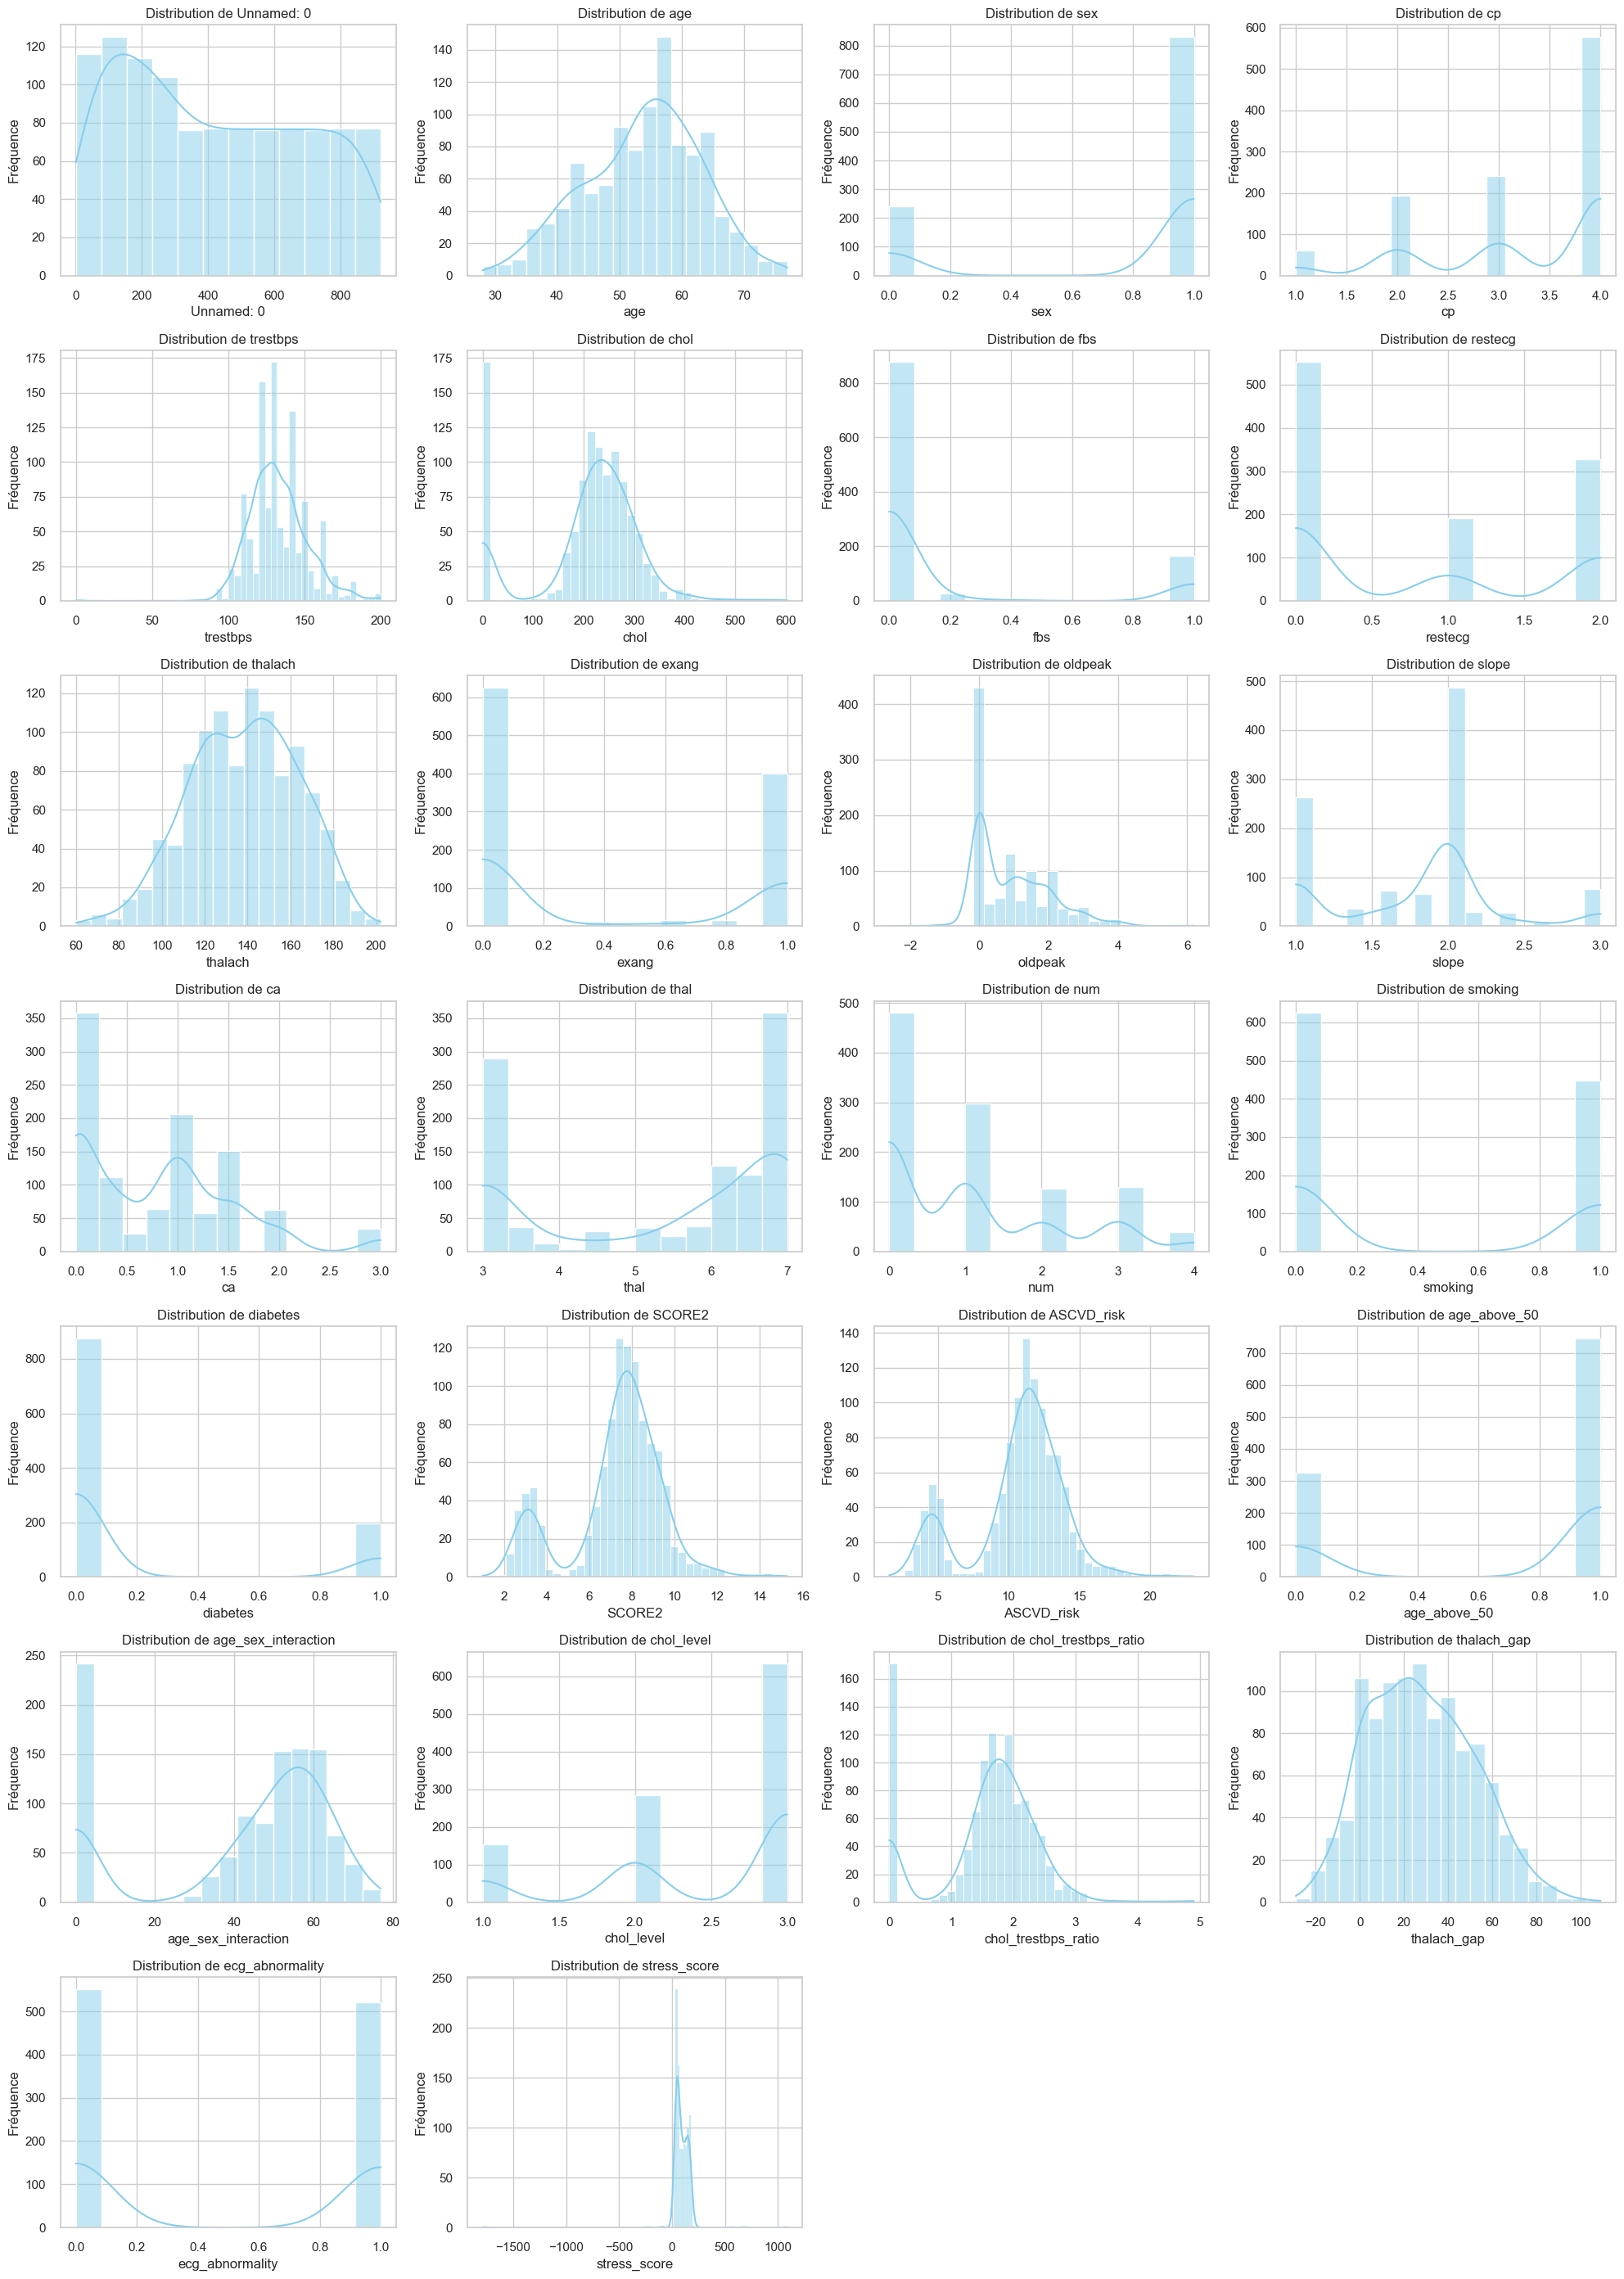

In [17]:
# Configurer le style de visualisation
sns.set(style="whitegrid")

# Créer une grille de sous-plots pour afficher les distributions
num_columns = df_processed.shape[1]
num_rows = (num_columns + 3) // 4  # 4 graphiques par ligne
fig, axes = plt.subplots(num_rows, 4, figsize=(20, num_rows * 4))
axes = axes.flatten()

# Afficher la distribution de chaque colonne
for i, col in enumerate(df_processed.columns):
    sns.histplot(df_processed[col], kde=True, ax=axes[i], color="skyblue")
    axes[i].set_title(f"Distribution de {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Fréquence")

# Supprimer les axes inutilisés s'il y en a
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

les données paraissent ok et pretes pour le training

# Modele developpement + export

In [26]:
import numpy as np
import pandas as pd
import time
import logging
import joblib
import pickle
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_validate, train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Configure logging
logging.basicConfig(filename="model_performance.log", level=logging.INFO,
                    format="%(asctime)s - %(message)s")

# Load dataset
df_processed = pd.read_csv("standarded_data_featureseng.csv")
X = df_processed.drop(columns=["num"])
y = df_processed["num"]

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# List of models and parameter grids
models = {
    'LogisticRegression': (LogisticRegression(max_iter=1000, random_state=42), {
        'clf__C': [0.1, 1, 10],
        'clf__solver': ['liblinear', 'lbfgs']
    }),
    'SVM': (SVC(random_state=42), {
        'clf__C': [0.1, 1, 10],
        'clf__kernel': ['linear', 'rbf']
    }),
    'KNeighbors': (KNeighborsClassifier(), {
        'clf__n_neighbors': [3, 5, 7],
        'clf__weights': ['uniform', 'distance']
    }),
    'DecisionTree': (DecisionTreeClassifier(random_state=42), {
        'clf__max_depth': [None, 10, 20],
        'clf__min_samples_split': [2, 5, 10]
    }),
    'RandomForest': (RandomForestClassifier(random_state=42), {
        'clf__n_estimators': [50, 100, 200],
        'clf__max_depth': [None, 10, 20],
        'clf__min_samples_split': [2, 5, 10]
    }),
    'GradientBoosting': (GradientBoostingClassifier(random_state=42), {
        'clf__n_estimators': [50, 100, 200],
        'clf__learning_rate': [0.01, 0.1, 0.5],
        'clf__max_depth': [3, 5, 7]
    }),
    'XGBoost': (XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'), {
        'clf__n_estimators': [50, 100, 200],
        'clf__learning_rate': [0.01, 0.1, 0.5],
        'clf__max_depth': [3, 5, 7]
    })
}

# Define metrics for cross-validation
metrics = {
    'accuracy': 'accuracy',
    'recall': 'recall_weighted',
    'precision': 'precision_weighted',
    'f1': 'f1_weighted',
    'roc_auc': 'roc_auc_ovr'  # For multiclass classification
}
results = []

# Loop over each model with tqdm for progress tracking
for model_name, (model, param_grid) in tqdm(models.items(), desc="Training models"):
    try:
        logging.info(f"Starting model: {model_name}")
        start_time = time.time()

        # Pipeline with RobustScaler and the model
        pipeline = Pipeline([
            ('clf', model)
        ])
        
        # Cross-validation and GridSearchCV setup
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        grid_search = GridSearchCV(pipeline, param_grid, cv=skf, scoring='accuracy', n_jobs=1, verbose=1)
        
        # Model training with GridSearchCV
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
        
        # Cross-validation evaluation on training set
        cv_results = cross_validate(best_model, X_train, y_train, cv=skf, scoring=metrics)
        
        # Calculate average scores
        scores = {metric: np.mean(cv_results[f'test_{metric}']) for metric in metrics}
        scores['training_time'] = time.time() - start_time
        scores['model'] = model_name
        scores['best_params'] = grid_search.best_params_

        # Log results
        logging.info(f"Model {model_name} completed with scores: {scores}")
        results.append(scores)

    except Exception as e:
        logging.error(f"Training failed for model {model_name}: {e}")
        print(f"Training failed for model {model_name}: {e}")

# Save performance results to CSV
performance_df = pd.DataFrame(results)
performance_df.to_csv("model_performance_summary.csv", index=False)
logging.info("All models evaluated, performance saved to model_performance_summary.csv")

# Selecting the best model based on accuracy (or other metric)
best_model_info = performance_df.loc[performance_df['accuracy'].idxmax()]
best_model_name = best_model_info['model']
best_params = best_model_info['best_params']

# Final training of the best model on the full training set
best_model_pipeline = Pipeline([
    ('clf', models[best_model_name][0].set_params(**{k.replace('clf__', ''): v for k, v in best_params.items()}))
])

# Train the best model on the full training set
best_model_pipeline.fit(X_train, y_train)

# Evaluate the model on the test set for a true hold-out performance measure
test_predictions = best_model_pipeline.predict(X_test)
test_accuracy = accuracy_score(y_test, test_predictions)
test_recall = recall_score(y_test, test_predictions, average='weighted')
test_precision = precision_score(y_test, test_predictions, average='weighted')
test_f1 = f1_score(y_test, test_predictions, average='weighted')
test_roc_auc = roc_auc_score(y_test, best_model_pipeline.predict_proba(X_test), multi_class="ovr")

# Log test set performance
logging.info(f"Test set performance for {best_model_name}:")
logging.info(f"Accuracy: {test_accuracy}, Recall: {test_recall}, Precision: {test_precision}, F1: {test_f1}, ROC AUC: {test_roc_auc}")

# Save the best model with joblib and pickle
joblib.dump(best_model_pipeline, f"best_model_{best_model_name}.joblib")
with open(f"best_model_{best_model_name}.pkl", 'wb') as f:
    pickle.dump(best_model_pipeline, f)

print(f"Best model {best_model_name} saved as best_model_{best_model_name}.joblib and best_model_{best_model_name}.pkl")


Training models:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 6 candidates, totalling 30 fits


Training models:  14%|█▍        | 1/7 [00:01<00:08,  1.42s/it]

Fitting 5 folds for each of 6 candidates, totalling 30 fits


Training models:  29%|██▊       | 2/7 [00:03<00:10,  2.07s/it]

Training failed for model SVM: Pipeline has none of the following attributes: predict_proba.
Fitting 5 folds for each of 6 candidates, totalling 30 fits


Training models:  43%|████▎     | 3/7 [00:04<00:05,  1.40s/it]

Fitting 5 folds for each of 9 candidates, totalling 45 fits


Training models:  57%|█████▋    | 4/7 [00:05<00:03,  1.13s/it]

Fitting 5 folds for each of 27 candidates, totalling 135 fits


Training models:  71%|███████▏  | 5/7 [00:46<00:31, 15.65s/it]

Fitting 5 folds for each of 27 candidates, totalling 135 fits


Training models:  86%|████████▌ | 6/7 [08:47<02:53, 173.83s/it]c:\Users\yskon\anaconda3.2\envs\heart_disease_env\lib\site-packages\xgboost\core.py:158: UserWarning: [22:30:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\yskon\anaconda3.2\envs\heart_disease_env\lib\site-packages\xgboost\core.py:158: UserWarning: [22:30:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting 5 folds for each of 27 candidates, totalling 135 fits


c:\Users\yskon\anaconda3.2\envs\heart_disease_env\lib\site-packages\xgboost\core.py:158: UserWarning: [22:30:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\yskon\anaconda3.2\envs\heart_disease_env\lib\site-packages\xgboost\core.py:158: UserWarning: [22:30:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\yskon\anaconda3.2\envs\heart_disease_env\lib\site-packages\xgboost\core.py:158: UserWarning: [22:30:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  w

Best model RandomForest saved as best_model_RandomForest.joblib and best_model_RandomForest.pkl


## on replace le contexte du benefique

2. Implement a Custom Scoring Function

Define a scoring function that calculates net benefits based on the formula provided:
Net Benefits=(TP×30000)−(FN×50000)−(FP×10000)
Net Benefits=(TP×30000)−(FN×50000)−(FP×10000)

In [27]:
from sklearn.metrics import make_scorer, confusion_matrix

def net_benefit(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    return (tp * 30000) - (fn * 50000) - (fp * 10000)

net_benefit_scorer = make_scorer(net_benefit, greater_is_better=True)


In [ ]:
import numpy as np
import pandas as pd
import time
import logging
import joblib
import pickle
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_validate, train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, make_scorer, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler

# Configure logging
logging.basicConfig(filename="model_performance.log", level=logging.INFO,
                    format="%(asctime)s - %(message)s")

# Custom scoring function for net benefits
def net_benefit(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    if cm.shape[0] == 2:
        tn, fp, fn, tp = cm.ravel()
    else:
        tn, fp, fn, tp = 0, 0, 0, 0  # Initialize variables if multiclass confusion matrix
        for i in range(len(cm)):
            tp += cm[i, i]
            fn += sum(cm[i, :]) - cm[i, i]
            fp += sum(cm[:, i]) - cm[i, i]
    return (tp * 30000) - (fn * 50000) - (fp * 10000)

net_benefit_scorer = make_scorer(net_benefit, greater_is_better=True)

# Load dataset
df_processed = pd.read_csv("standarded_data_featureseng.csv")
X = df_processed.drop(columns=["num"])
y = df_processed["num"]

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Define models and hyperparameter grids for the top 3 models
models = {
    'RandomForest': (RandomForestClassifier(random_state=42, class_weight="balanced"), {
        'clf__n_estimators': [50, 100, 200, 300],
        'clf__max_depth': [None, 10, 20, 30],
        'clf__min_samples_split': [2, 5, 10],
        'clf__min_samples_leaf': [1, 2, 4],
        'clf__bootstrap': [True, False]
    }),
    'GradientBoosting': (GradientBoostingClassifier(random_state=42), {
        'clf__n_estimators': [50, 100, 200, 300],
        'clf__learning_rate': [0.01, 0.1, 0.2, 0.3],
        'clf__max_depth': [3, 5, 7],
        'clf__min_samples_split': [2, 5, 10]
    }),
    'XGBoost': (XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'), {
        'clf__n_estimators': [50, 100, 200, 300],
        'clf__learning_rate': [0.01, 0.1, 0.2, 0.3],
        'clf__max_depth': [3, 5, 7],
        'clf__min_child_weight': [1, 3, 5],
        'clf__gamma': [0, 0.1, 0.2]
    })
}

# Define evaluation metrics
metrics = ['accuracy', 'recall_weighted', 'precision_weighted', 'f1_weighted', 'roc_auc_ovr']
results = []

# Loop over each model with tqdm for progress tracking
for model_name, (model, param_grid) in tqdm(models.items(), desc="Training models"):
    try:
        logging.info(f"Starting model: {model_name}")
        start_time = time.time()

        # Pipeline with RobustScaler and the model
        pipeline = Pipeline([
            ('clf', model)
        ])
        
        # Cross-validation and GridSearchCV setup
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        grid_search = GridSearchCV(pipeline, param_grid, cv=skf, scoring=net_benefit_scorer, n_jobs=1, verbose=1)
        
        # Model training with GridSearchCV
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
        
        # Cross-validation evaluation on training set
        cv_results = cross_validate(best_model, X_train, y_train, cv=skf, scoring=metrics, n_jobs=1)
        
        # Calculate average scores
        scores = {metric: np.mean(cv_results[f'test_{metric}']) for metric in metrics}
        scores['net_benefit'] = net_benefit(y_train, best_model.predict(X_train))  # Explicitly calculate net benefit
        scores['training_time'] = time.time() - start_time
        scores['model'] = model_name
        scores['best_params'] = grid_search.best_params_

        # Log results
        logging.info(f"Model {model_name} completed with scores: {scores}")
        results.append(scores)

    except Exception as e:
        logging.error(f"Training failed for model {model_name}: {e}")
        print(f"Training failed for model {model_name}: {e}")

# Save performance results to CSV
performance_df = pd.DataFrame(results)
performance_df.to_csv("model_performance_summary.csv", index=False)
logging.info("All models evaluated, performance saved to model_performance_summary.csv")

# Selecting the best model based on net benefit
try:
    best_model_info = performance_df.loc[performance_df['net_benefit'].idxmax()]
    best_model_name = best_model_info['model']
    best_params = best_model_info['best_params']
except KeyError:
    print("Error: 'net_benefit' not found in performance data. Check scoring and metrics.")
    logging.error("Error: 'net_benefit' not found in performance data.")

# Final training of the best model on the full training set
best_model_pipeline = Pipeline([
    ('clf', models[best_model_name][0].set_params(**{k.replace('clf__', ''): v for k, v in best_params.items()}))
])

# Train the best model on the full training set
best_model_pipeline.fit(X_train, y_train)

# Evaluate the model on the test set for a true hold-out performance measure
test_predictions = best_model_pipeline.predict(X_test)
test_net_benefit = net_benefit(y_test, test_predictions)

# Log test set performance
logging.info(f"Test set net benefit for {best_model_name}: {test_net_benefit}")
print(f"Test set net benefit for {best_model_name}: {test_net_benefit}")

# Save the best model with joblib and pickle
joblib.dump(best_model_pipeline, f"best_model_benef_{best_model_name}.joblib")
with open(f"best_model_benef_{best_model_name}.pkl", 'wb') as f:
    pickle.dump(best_model_pipeline, f)

print(f"Best model {best_model_name} saved as best_model_{best_model_name}.joblib and best_model_{best_model_name}.pkl")


Training models:   0%|          | 0/3 [00:00<?, ?it/s]

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


Training models:  33%|███▎      | 1/3 [07:11<14:22, 431.08s/it]

Fitting 5 folds for each of 144 candidates, totalling 720 fits
